In [1]:
import matplotlib.pyplot as plt
import wntr
import wntr.network.controls as controls
import sqlite3
import csv
import time
import pandas as pd

In [20]:
# Create the network
inp_file = '../EPANET_topologies/ctown_map_base.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# We define the simulation times in seconds
#wn.options.time.duration = 24
wn.options.time.duration = 1
wn.options.time.hydraulic_timestep = 5*60
wn.options.time.quality_timestep = 5*60
wn.options.time.pattern_timestep = 60*60
wn.options.time.report_timestep = 5*60

list_header = []
node_list = list(wn.node_name_list)
link_list = list(wn.link_name_list)

C:\Users\Azulm\Anaconda3\lib\site-packages\wntr\epanet\io.py:2085: UserWarning: Not all curves were used in "../EPANET_topologies/ctown_map_base.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))


In [32]:
def get_node_list_by_type(list, type):
    result = []
    for node in list:
        if wn.get_node(node).node_type == type:
            result.append(str(node))
    return result

def get_link_list_by_type(list, type):
    result = []
    for link in list:
        if wn.get_link(link).link_type == type:
            result.append(str(link))
    return result

def create_node_header(list):
    result = []
    for node in list:
        result.append(node+"_LEVEL")
    return result

def create_link_header(list):
    result = []
    for link in list:
        result.append(link+"_FLOW")
        result.append(link+"_STATUS")
    return result

def get_controls(list):
    result = []
    for control in list:
        result.append(wn.get_control(control))
    return result

def create_control_dict(actuator):
    dummy_condition = controls.ValueCondition(wn.get_node('T1'), 'level', '>=', -1)
    act_dict = dict.fromkeys(['actuator', 'parameter', 'value', 'condition', 'name'])
    act_dict['actuator'] = wn.get_link(actuator)
    act_dict['parameter'] = 'status'
    act_dict['condition'] = dummy_condition
    act_dict['name'] = actuator + "_control"
    if type(wn.get_link(actuator).status) is int:
                act_dict['value'] = act_dict['actuator'].status
    else:
                act_dict['value'] = act_dict['actuator'].status.value   
    return act_dict
    
def register_results(results):
    values_list = []    
    values_list.extend([results.timestamp])
    
    #Results are divided into: nodes: reservoir and tanks, links: flows and status
    # Get tanks levels
    for tank in tank_list:
            values_list.extend([wn.get_node(tank).level])

    # Get junction  levels         
    for junction in junction_list:
            values_list.extend([wn.get_node(junction).head - wn.get_node(junction).elevation])

    # Get pumps flows and status
    for pump in pump_list:
            values_list.extend([wn.get_link(pump).flow])

            if type(wn.get_link(pump).status) is int:
                values_list.extend([wn.get_link(pump).status])  # The value is an integer
            else:
                values_list.extend([wn.get_link(pump).status.value]) # The value is an attribute of status, integer

    # Get valves flows and status
    for valve in valve_list:
            values_list.extend([wn.get_link(valve).flow])

            if type(wn.get_link(valve).status) is int:
                values_list.extend([wn.get_link(valve).status])
            else:
                values_list.extend([wn.get_link(valve).status.value]) 
    return values_list

In [33]:
aux = get_node_list_by_type(node_list, 'Tank')
for tank in aux:
    a_level = wn.get_node(tank).level

['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7']

0.5

In [8]:
wntr_only = 1
#reservoir_list = get_node_list_by_type(node_list, 'Reservoir')
tank_list      = get_node_list_by_type(node_list, 'Tank')
junction_list  = get_node_list_by_type(node_list, 'Junction')
pump_list      = get_link_list_by_type(link_list, 'Pump')
valve_list     = get_link_list_by_type(link_list, 'Valve')
#control_names  = wn.control_name_list

list_header = ["Timestamps"]
aux = create_node_header(tank_list)
list_header.extend(aux)

aux = create_node_header(junction_list)
list_header.extend(aux)

aux = create_link_header(pump_list)
list_header.extend(aux)

aux = create_link_header(valve_list)
list_header.extend(aux)

results_list = []
results_list.append(list_header)

#control_list_str = get_controls(control_names)

control_list = []
for valve in valve_list:
    control_list.append(create_control_dict(valve))

for pump in pump_list:
    control_list.append(create_control_dict(pump))

if wntr_only == 0:
    for control in control_list:
        #act1 = controls.ControlAction(pump1, 'status', int(pump1_status))
        an_action = controls.ControlAction(control['actuator'], control['parameter'], control['value'])
        a_control = controls.Control(control['condition'], an_action, control['name'])
        wn.add_control(control['name'], a_control)

In [11]:
wn.get_control('control 1')

<Control: '', <ValueCondition: T1, level, <=, 4.0>, [<ControlAction: PU1, status, Open>], [], priority=3>

In [12]:
wn.get_control('v1_control')

<Control: '', <ValueCondition: T1, level, >=, -1.0>, [<ControlAction: v1, status, Active>], [], priority=v1_control>

In [11]:
# START STEP BY STEP SIMULATION
sim = wntr.sim.WNTRSimulator(wn, mode='PDD')
iteration = 0
days = 1
iteration_limit = (days*24*3600)/wn.options.time.hydraulic_timestep
while iteration <= iteration_limit:
    
    #update_actuator_values()
    
    results = sim.run_sim(convergence_error=True)
    values_list = register_results(results)
    
    results_list.append(values_list)    
    iteration += 1

In [12]:
with open('ctown_no_minicps.csv', 'w', newline='\n') as f:
    writer = csv.writer(f)
    writer.writerows(results_list)

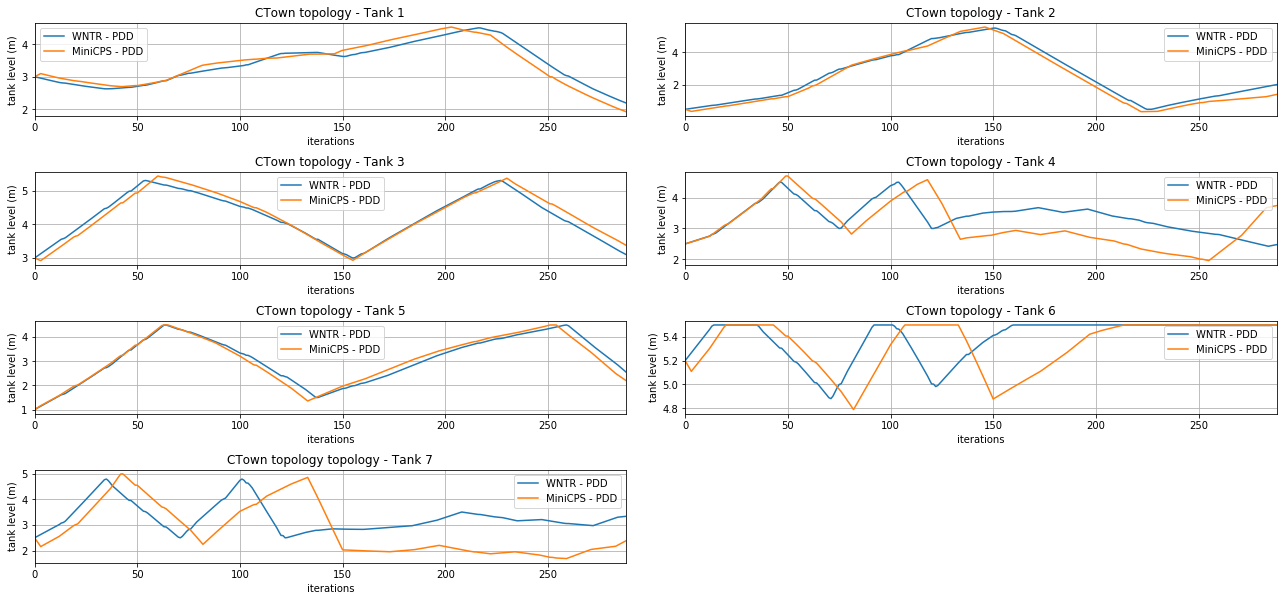

In [2]:
no_minicps_ctown = pd.read_csv('ctown_no_minicps.csv')
minicps_ctown = pd.read_csv('../ICS_topologies/ctown_topology/output/physical_process.csv')

subplot_hspace = 0.6
subplot_wspace = 0.1

dd = plt.subplot(4,2,1)
no_minicps_ctown["T1_LEVEL"].plot(label='WNTR - PDD', ax=dd)
minicps_ctown["T1_LEVEL"].plot(label='MiniCPS - PDD', ax=dd)
plt.title("CTown topology - Tank 1")
plt.xlabel('iterations')
plt.ylabel('tank level (m)')
plt.legend()
plt.subplots_adjust(top=2.00, right=3.00, hspace = subplot_hspace, wspace=subplot_wspace)
plt.grid(True)

dd = plt.subplot(4,2,2)
no_minicps_ctown["T2_LEVEL"].plot(label='WNTR - PDD', ax=dd)
minicps_ctown["T2_LEVEL"].plot(label='MiniCPS - PDD', ax=dd)
plt.title("CTown topology - Tank 2")
plt.xlabel('iterations')
plt.ylabel('tank level (m)')
plt.legend()
plt.subplots_adjust(top=2.00, right=3.00, hspace = subplot_hspace, wspace=subplot_wspace)
plt.grid(True)

dd = plt.subplot(4,2,3)
no_minicps_ctown["T3_LEVEL"].plot(label='WNTR - PDD', ax=dd)
minicps_ctown["T3_LEVEL"].plot(label='MiniCPS - PDD', ax=dd)
plt.title("CTown topology - Tank 3")
plt.xlabel('iterations')
plt.ylabel('tank level (m)')
plt.legend()
plt.subplots_adjust(top=2.00, right=3.00, hspace = subplot_hspace, wspace=subplot_wspace)
plt.grid(True)

dd = plt.subplot(4,2,4)
no_minicps_ctown["T4_LEVEL"].plot(label='WNTR - PDD', ax=dd)
minicps_ctown["T4_LEVEL"].plot(label='MiniCPS - PDD', ax=dd)
plt.title("CTown topology - Tank 4")
plt.xlabel('iterations')
plt.ylabel('tank level (m)')
plt.legend()
plt.subplots_adjust(top=2.00, right=3.00, hspace = subplot_hspace, wspace=subplot_wspace)
plt.grid(True)

dd = plt.subplot(4,2,5)
no_minicps_ctown["T5_LEVEL"].plot(label='WNTR - PDD', ax=dd)
minicps_ctown["T5_LEVEL"].plot(label='MiniCPS - PDD', ax=dd)
plt.title("CTown topology - Tank 5")
plt.xlabel('iterations')
plt.ylabel('tank level (m)')
plt.legend()
plt.subplots_adjust(top=2.00, right=3.00, hspace = subplot_hspace, wspace=subplot_wspace)
plt.grid(True)

dd = plt.subplot(4,2,6)
no_minicps_ctown["T6_LEVEL"].plot(label='WNTR - PDD', ax=dd)
minicps_ctown["T6_LEVEL"].plot(label='MiniCPS - PDD', ax=dd)
plt.title("CTown topology - Tank 6")
plt.xlabel('iterations')
plt.ylabel('tank level (m)')
plt.legend()
plt.subplots_adjust(top=2.00, right=3.00, hspace = subplot_hspace, wspace=subplot_wspace)
plt.grid(True)

dd = plt.subplot(4,2,7)
no_minicps_ctown["T7_LEVEL"].plot(label='WNTR - PDD', ax=dd)
minicps_ctown["T7_LEVEL"].plot(label='MiniCPS - PDD', ax=dd)
plt.title("CTown topology topology - Tank 7")
plt.xlabel('iterations')
plt.ylabel('tank level (m)')
plt.legend()
plt.subplots_adjust(top=2.00, right=3.00, hspace = subplot_hspace, wspace=subplot_wspace)
plt.grid(True)

In [9]:
plcs=[]
for i in range(1,10):
    if i == 8:
        continue
    plcs.append(i)

In [10]:
plcs

[1, 2, 3, 4, 5, 6, 7, 9]

In [15]:
sender_plcs = [plcs[1], plcs[3], plcs[5], plcs[6], plcs[7]]
receiver_plcs = [plcs[0], plcs[2], plcs[4]]

print(str(sender_plcs))
print(str(receiver_plcs))

[2, 4, 6, 7, 9]
[1, 3, 5]
